Predict number of rented bikes using SARIMA and SARIMAX 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import itertools 
import warnings
from  statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
df1=pd.read_csv('day.csv', parse_dates=['dteday'])
df1

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Drop some unnecessary data

In [2]:
df1=df1.drop(['instant','casual'], axis=1)

Plot histograms

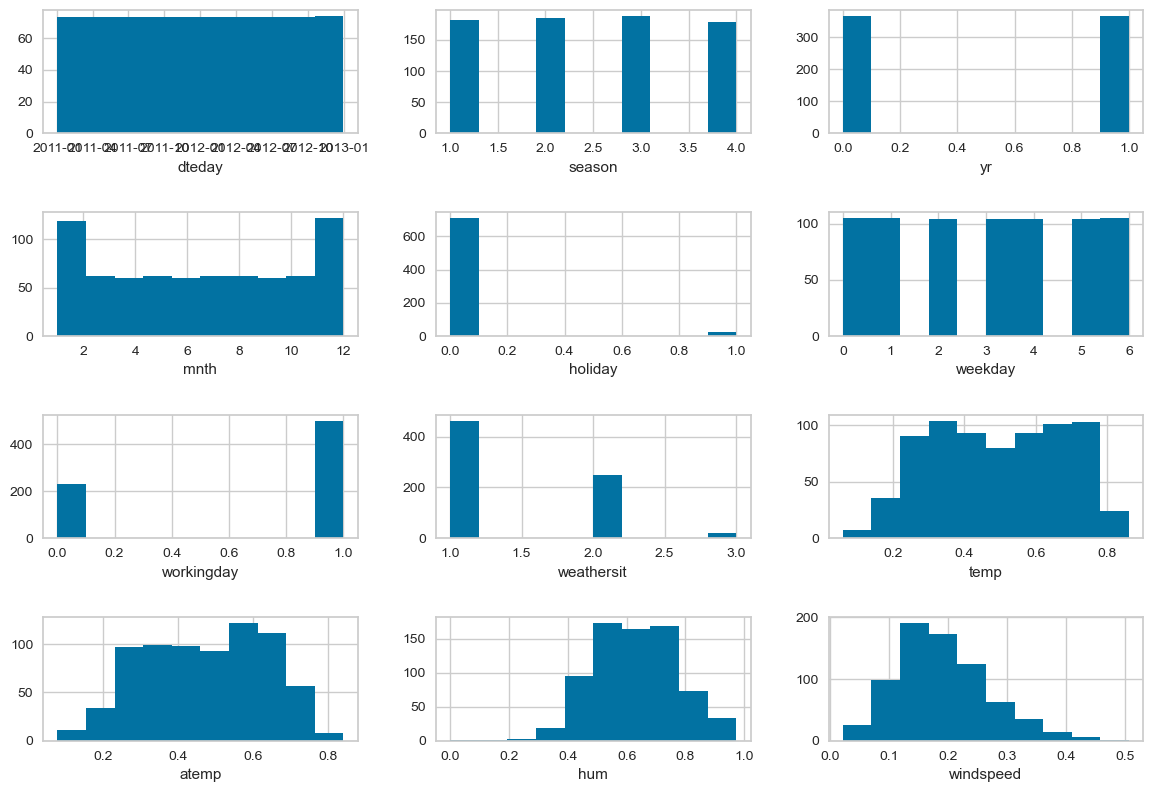

In [3]:
fig=plt.figure(figsize=(12,10))
count=0
for i in range(4):
    for j in range(3):
        plt.subplot2grid((5,3),(i,j))
        plt.hist(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1


Plot box

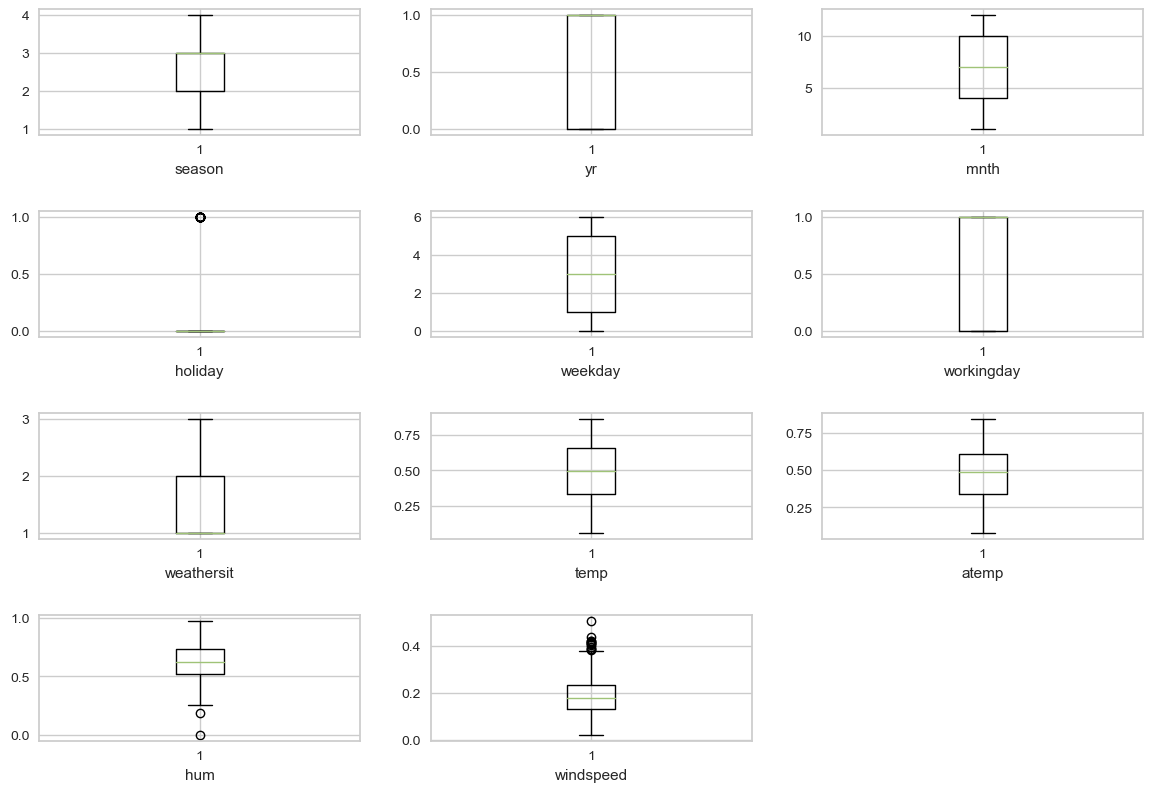

In [5]:
fig=plt.figure(figsize=(12,10))
count=1
for i in range(4):
    for j in range(3):
        if count== 12:
            break
        plt.subplot2grid((5,3),(i,j))
        plt.boxplot(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1

Check if there is any duplicated data

In [4]:
df1.duplicated().sum()

0

Check if there is any nun value

In [5]:
df1.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
registered    0
cnt           0
dtype: int64

In [6]:
df1['dteday'].describe()

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_7861/916621911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1['dteday'].describe()


count                     731
unique                    731
top       2011-01-01 00:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

I select the train to be from the first of 2011 till first of May 2012 and the rest of months of 2021 serves as test dataset

In [7]:
df1=df1.set_index('dteday')

In [10]:
df1

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt
dteday,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,654,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,670,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1229,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1454,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,1867,2114
2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,2451,3095
2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1182,1341


Plot the time series to see any trend or seasonality

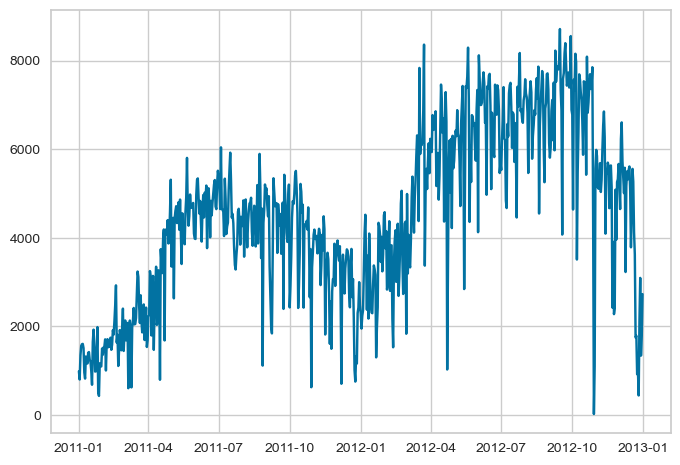

In [8]:
plt.plot(df1['cnt'])

There is a yearly and weekly seasonality. 

Decompose the time series

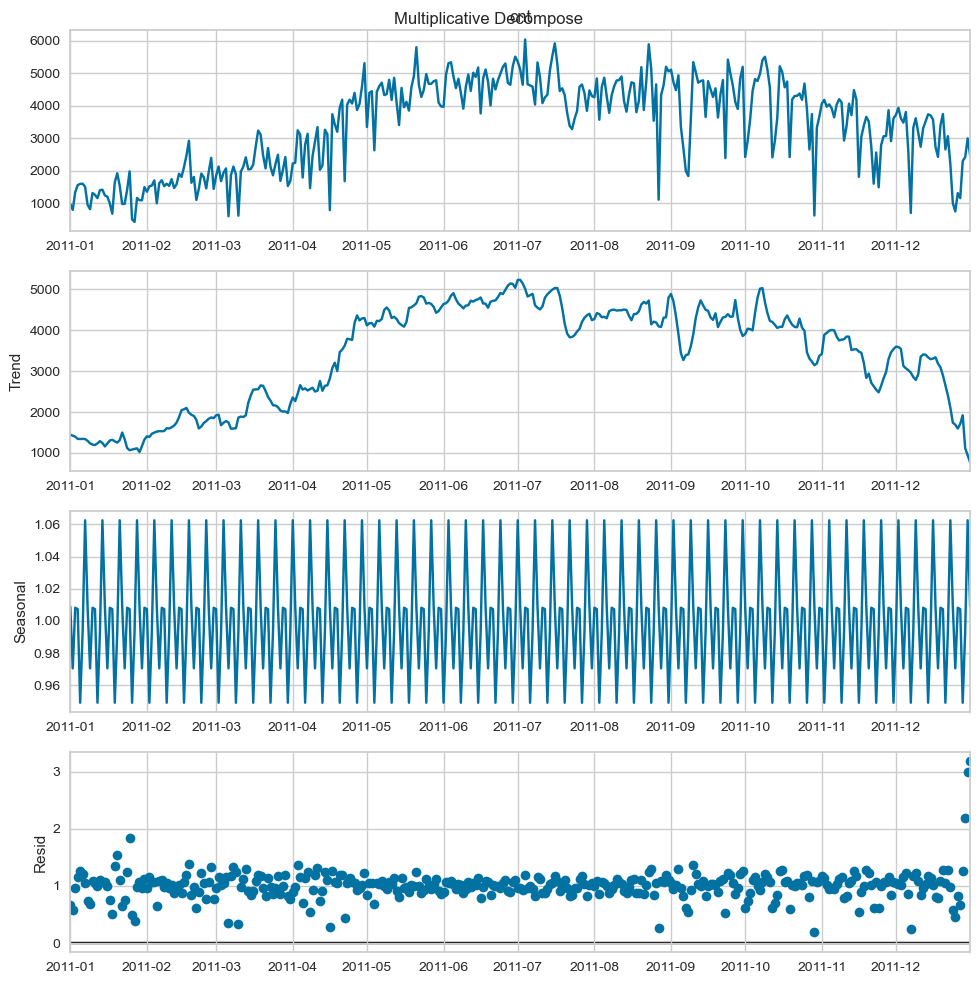

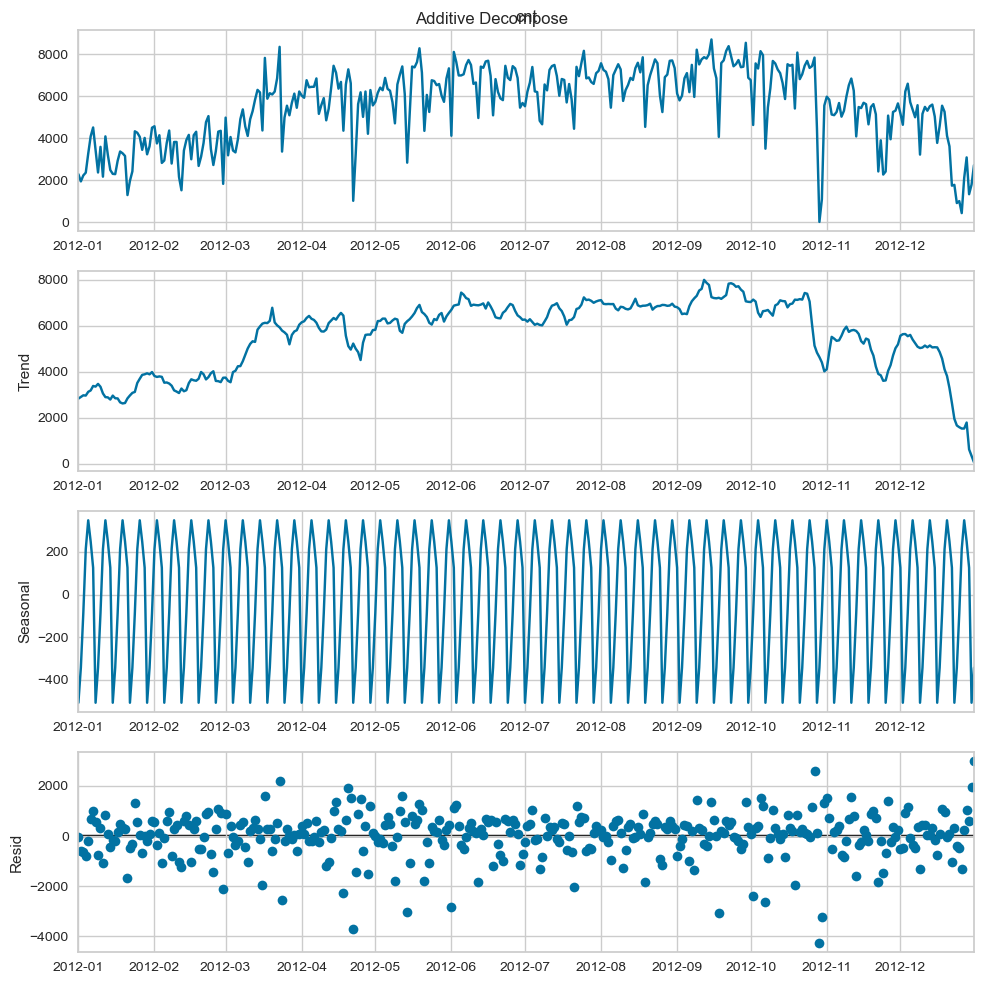

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data

# Multiplicative Decomposition 
result_mul_total = seasonal_decompose(df1['cnt'][df1['yr']==0], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add_total = seasonal_decompose(df1['cnt'][df1['yr']==1], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul_total.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add_total.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

In [8]:
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed_total = pd.concat([result_add_total.seasonal, result_add_total.trend, result_add_total.resid, result_add_total.observed], axis=1)
df_reconstructed_total.columns = ['seasonality', 'trend', 'residuals', 'time_series']
df_reconstructed_total.head()

,seasonality,trend,residuals,time_series
dteday,,,,
2012-01-01,-506.552057,2830.744898,-30.192841,2294.0
2012-01-02,-342.331995,2902.260204,-608.928209,1951.0
2012-01-03,-86.677801,2973.775510,-651.097709,2236.0
2012-01-04,212.806893,2962.857143,-807.664036,2368.0
2012-01-05,348.098102,3124.428571,-200.526673,3272.0


Plot seasonality for the fisrt days 

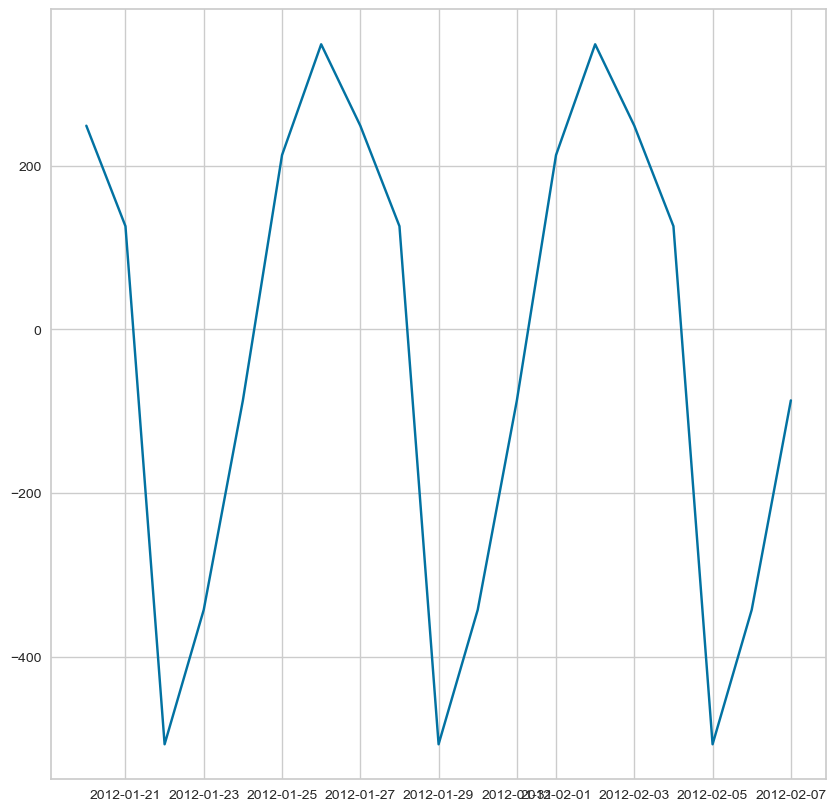

In [13]:
c=df_reconstructed_total[(df_reconstructed_total.index < '2012-02-08') & (df_reconstructed_total.index > '2012-01-19')]
plt.plot(c['seasonality'])

Plot ACF and PACF

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


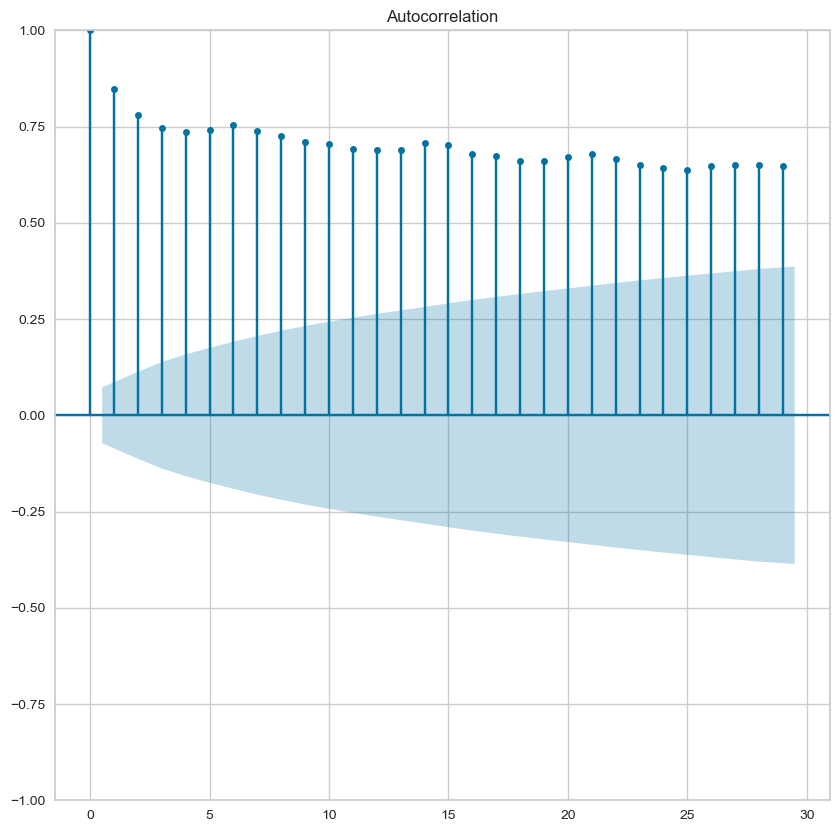

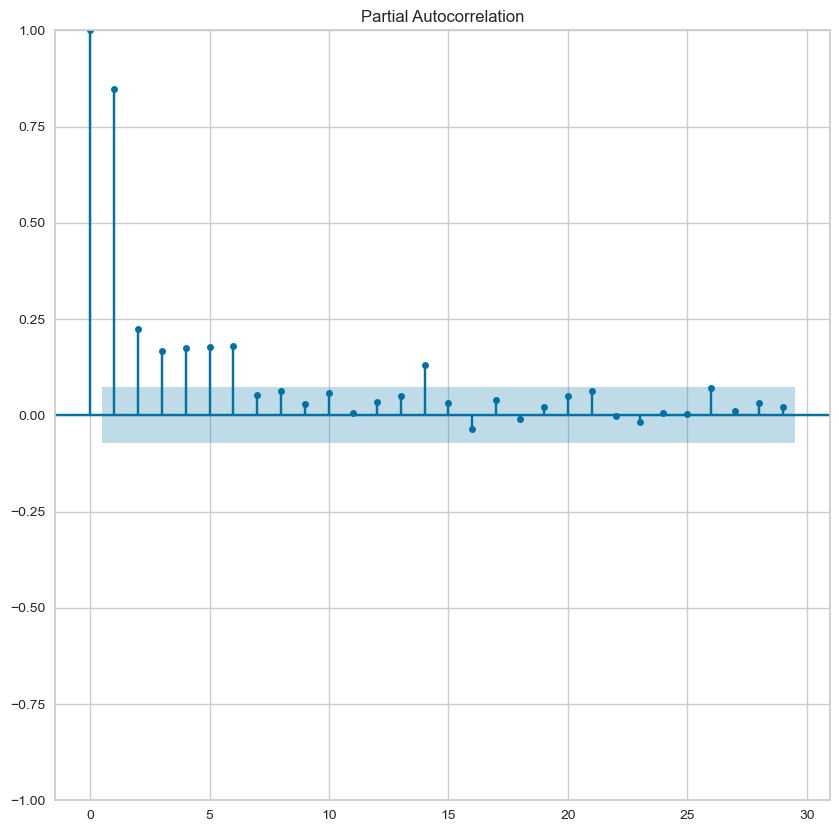

In [14]:
acf_df1=plot_acf(df1['cnt'])
pacf_df1=plot_pacf(df1['cnt'])

Make the stationary test using ADF

In [7]:
result=adfuller(df1.cnt)
print('P-value: ',result[1])

P-value:  0.3427434403392201


Since p is larger than significant value (0.05), null hypothesis is valid (time series is non-stationary). Let's make the time series stationary and then look at the ACF and PACF again

In [8]:
df1_a=df1.diff().dropna()

check the stazionarity of time series

In [9]:
result=adfuller(df1_a.cnt)
print('P-value: ',result[1])


P-value:  1.0467797548019514e-21


So p value is smaller than significant value (0.05), therefore time series is stationary. So with one differencing , time series becomes stationary (d=1). Plot ACF and PACF again for the stationary time series.

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


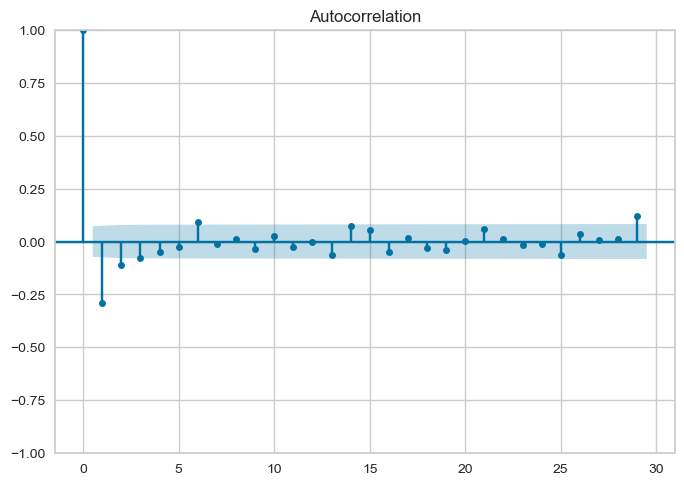

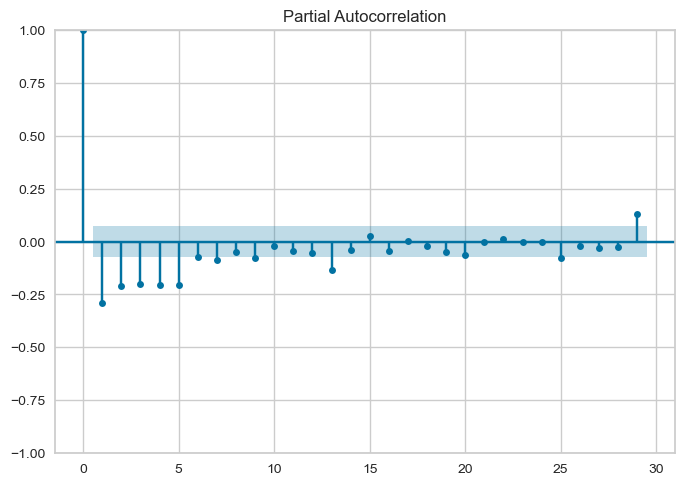

In [12]:
acf_df1_a=plot_acf(df1_a['cnt'])
pacf_df1_a=plot_pacf(df1_a['cnt'])

First split the data to train and test

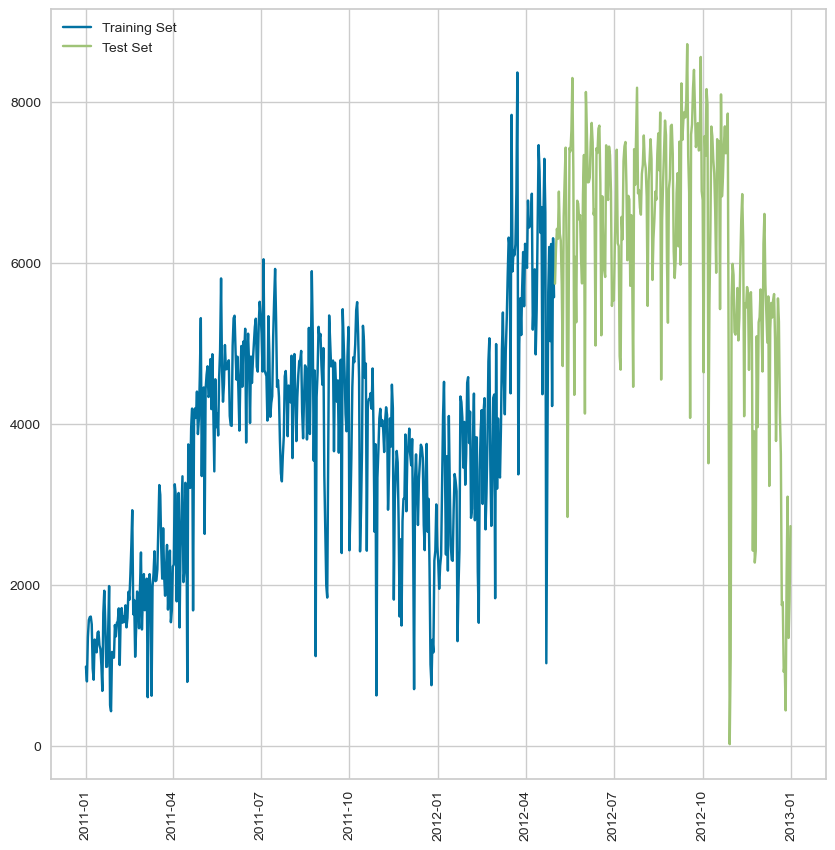

In [11]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
plt.plot(train.index, train['cnt'])
plt.plot(test.index, test['cnt'])
plt.xticks(rotation=90)
plt.legend(['Training Set', 'Test Set'])

plt.show()

Plotting cross-validation 

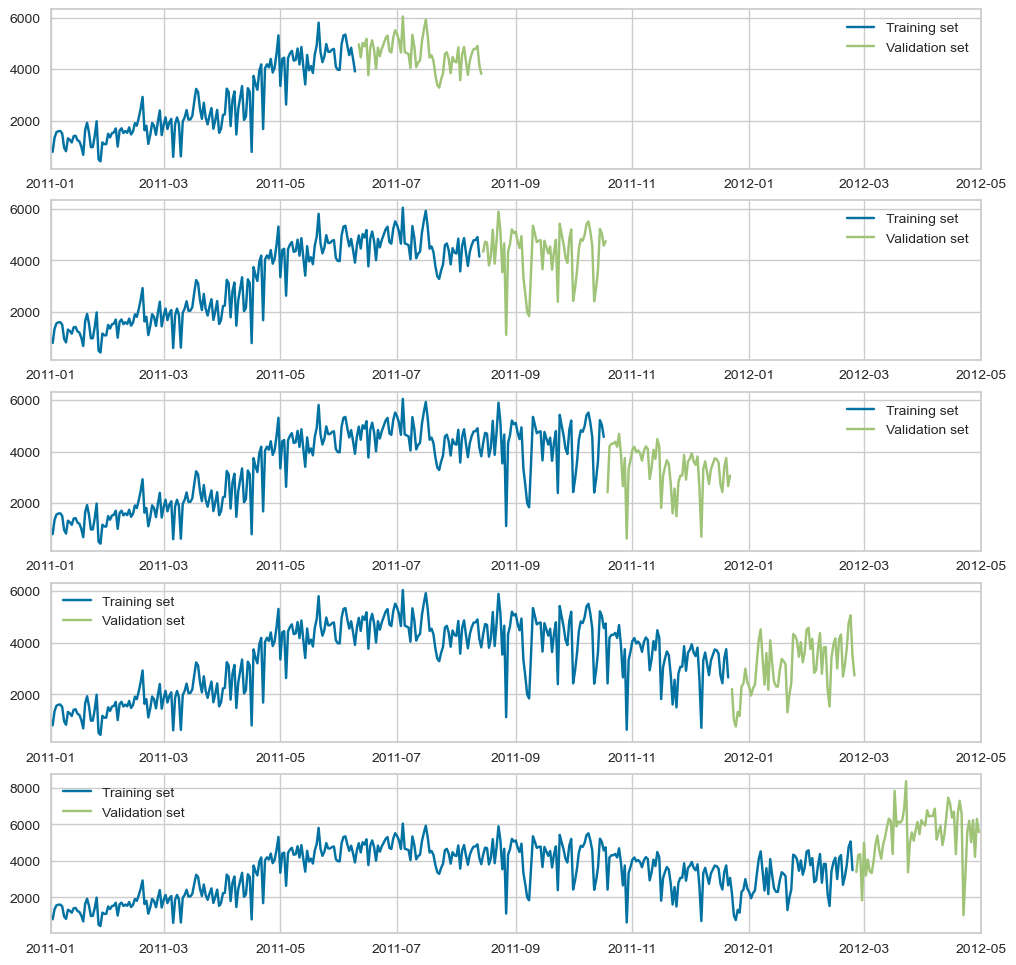

In [15]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
fig=plt.figure(figsize=(12,12))

count=0
for train_in, val_in in cross_val.split(train):
    train_valid=df1.iloc[train_in]
    validation=df1.iloc[val_in]
    plt.subplot2grid((5,1),(count,0))
    plt.plot(train_valid.index, train_valid['cnt'])
    plt.plot(validation.index,validation['cnt'])
    plt.legend(['Training set','Validation set'])
    plt.xlim([dt.date(2011, 1, 1), dt.date(2012, 5, 1)])
    count+=1

plt.show()

Define x and y and fit the model 

In [19]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

warnings.filterwarnings("ignore") # specify to ignore warning messages

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    x_val=validation['cnt']
    AIC=[]
    SARIMAX_model=[]
    q=range(0,3)
    d=range(0,2)
    p=range(0,5)
    pdq=list(itertools.product(p, d, q))
    seas=[(a[0],a[1],a[2], 7)  for a in pdq]
    for param in pdq:
        for param_seasonal in seas:
            try:

                mod = SARIMAX(x_train,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit(disp=False)


                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')

                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue



print(AIC)


[8064.401793101278, 7782.509408783976, 7256.150117525002, 6917.0920822782455, 6667.477324820083, 6557.125911680112, 6929.26172312548, 6779.003139403835, 6668.607528973263, 6726.136223578974, 6666.778439823602, 6553.0564046234285, 6727.336258378378, 6685.227336804846, 6667.840175979682, 6578.454893278582, 6569.760221670666, 6552.31250668494, 6580.439626725516, 6573.711716948874, 6573.033674112527, 6458.167335712533, 6458.407835541104, 6457.6387525550535, 6460.062251937099, 6461.974238437031, 6461.962944552307, 6347.131800772955, 6348.244750472011, 6348.11632087624, 7624.558945335424, 7293.1400910865395, 7048.738132210847, 6864.0344095437085, 6588.514031092129, 6477.281332222004, 6887.561844128294, 6895.850997961479, 6589.320751941573, 6679.192421024469, 6586.831266499148, 6477.663954008922, 6679.04688797722, 6620.959912776558, 6592.614599930326, 6521.9656833525505, 6506.4640289105555, 6477.013742974188, 6523.679058055927, 6510.12060333399, 7196.110073905149, 6399.841881732349, 6397.0560

In [20]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 6148.829657609115 for model SARIMAX(4, 1, 1)x(4, 1, 1, 7)


Apply on the whole train dataset

In [21]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','registered','atemp','hum'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','registered','atemp','hum'], axis=1)

model = SARIMAX(x_train_total,order=SARIMAX_model[AIC.index(min(AIC))][0],
                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  486
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 7)   Log Likelihood               -3667.176
Date:                           Mon, 06 Feb 2023   AIC                           7356.351
Time:                                   21:03:31   BIC                           7401.455
Sample:                               01-01-2011   HQIC                          7374.135
                                    - 04-30-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4385      0.049    -29.111      0.000      -1.535      -1.342
ar.L2         -0.7253      0.083     -8.755

Plot residuals

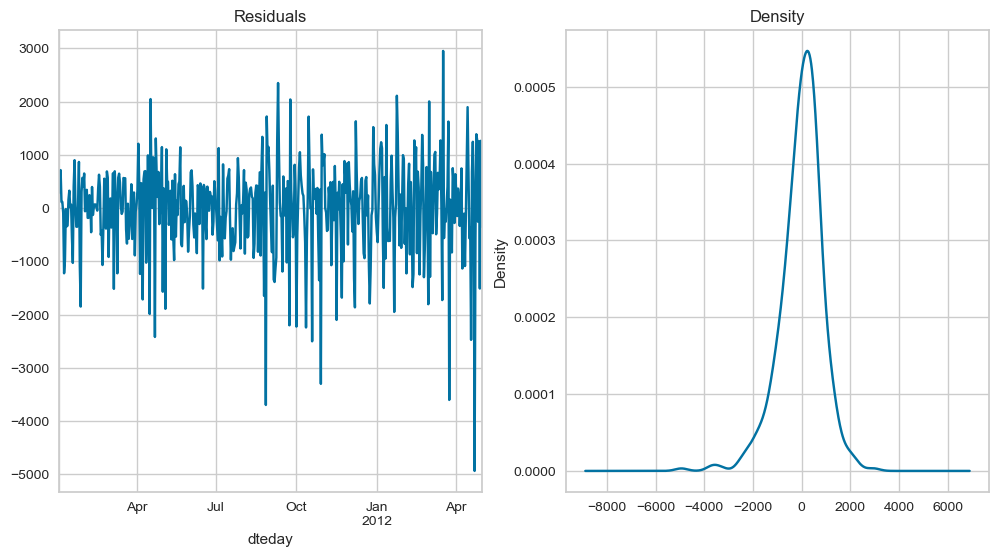

In [22]:
residuals = model_fit.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
residuals.plot(title='Residuals')
plt.subplot2grid((1,2),(0,1))

residuals.plot(title='Density', kind='kde')
plt.show()

Let's plot the ACF and PACF of residuals. As it is obsious from above plots, there are some residuals which are beyond the significant interval, indicating that our model could not perform good (it is also clear from the magnitude of residuals).  

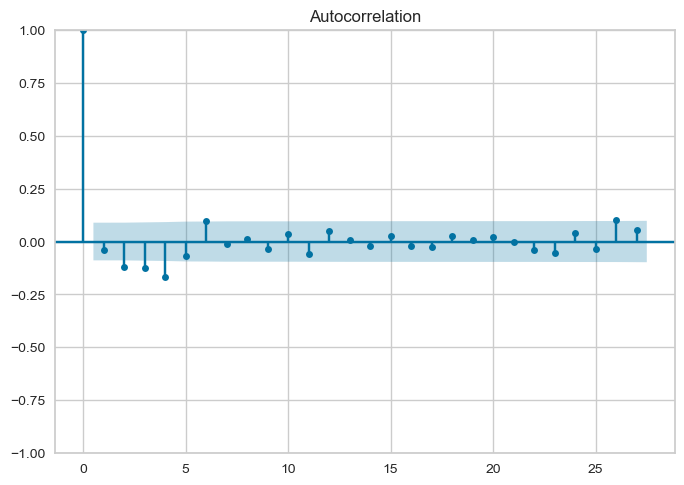

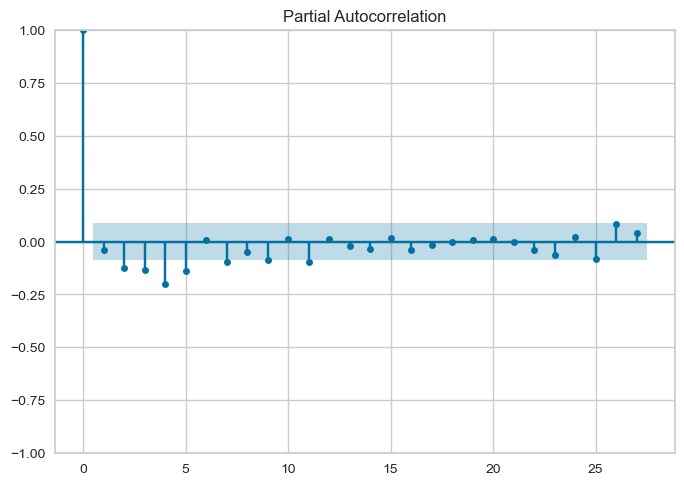

In [23]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

Plot prediction and observation

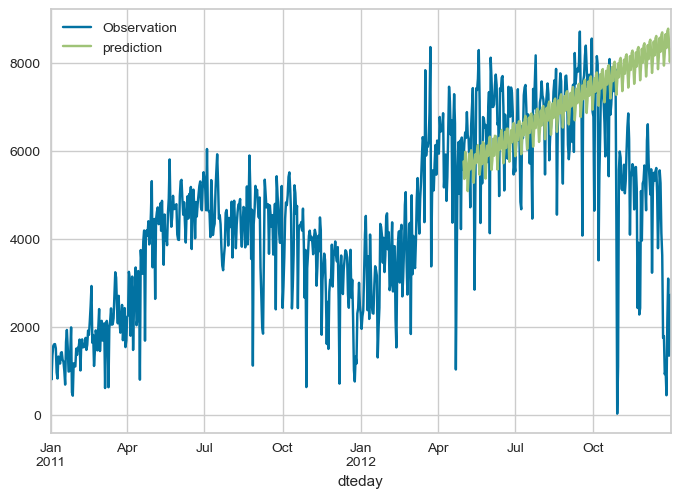

In [24]:
forecast_test = model_fit.forecast(len(x_test))
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])


Plot the prediction part only (zoom in of the above figure)

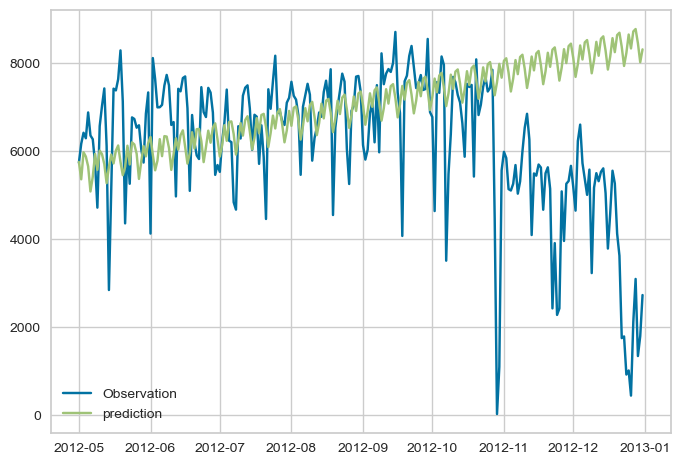

In [25]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

MAE and r square

In [26]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  1556.0802736631722
Rsquare is:  -1.0168012497152934


Use Sarimax with exog. I add some of features of the df1 to the model to see any improvements.

In [16]:
test.drop(['mnth','weekday'],axis=1, inplace=True)
train.drop(['mnth','weekday'], axis=1, inplace=True)

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_3595/858560721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['mnth','weekday'],axis=1, inplace=True)


In [17]:
test.drop(['atemp','hum','registered'],axis=1, inplace=True)
train.drop(['atemp','hum','registered'], axis=1, inplace=True)

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_3595/1627201864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['atemp','hum','registered'],axis=1, inplace=True)


cross validation + grid search

In [18]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

warnings.filterwarnings("ignore") # specify to ignore warning messages

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt'], axis=1)
    x_val=validation['cnt']
    AIC=[]
    SARIMAX_model=[]
    q=range(0,3)
    d=range(0,2)
    p=range(0,5)
    pdq=list(itertools.product(p, d, q))
    seas=[(a[0],a[1],a[2], 7)  for a in pdq]
    for param in pdq:
        for param_seasonal in seas:
            try:

                mod = SARIMAX(x_train,order=param,exog=y_train,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit(disp=False)


                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')

                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue

The best model is the one with minimum AIC

In [19]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 5974.6385243732275 for model SARIMAX(4, 1, 1)x(4, 1, 2, 7)


Let's fit the best model

In [22]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt'], axis=1)
           

model = SARIMAX(x_train,order=SARIMAX_model[AIC.index(min(AIC))][0],exog=y_train,
                                            seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
model_fit=model.fit(disp=False)
model_fit.summary()
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                    cnt   No. Observations:                  420
Model:             SARIMAX(4, 1, 1)x(4, 1, [1, 2], 7)   Log Likelihood               -2968.319
Date:                                Tue, 07 Feb 2023   AIC                           5974.639
Time:                                        04:45:38   BIC                           6049.502
Sample:                                    01-01-2011   HQIC                          6004.345
                                         - 02-24-2012                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season       273.5433     92.098      2.970      0.003      93.034     454.053
yr 

Since holiday has high p value I remove it

In [23]:
test.drop(['holiday'],axis=1, inplace=True)
train.drop(['holiday'], axis=1, inplace=True)

In [28]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt'], axis=1)
           

model = SARIMAX(x_train_total,order=SARIMAX_model[AIC.index(min(AIC))][0],exog=y_train_total,
                                            seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
model_fit=model.fit(disp=False)
model_fit.summary()
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                    cnt   No. Observations:                  486
Model:             SARIMAX(4, 1, 1)x(4, 1, [1, 2], 7)   Log Likelihood               -3536.720
Date:                                Tue, 07 Feb 2023   AIC                           7109.440
Time:                                        04:52:54   BIC                           7183.246
Sample:                                    01-01-2011   HQIC                          7138.540
                                         - 04-30-2012                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season       318.8218    142.938      2.230      0.026      38.669     598.975
yr 

Remove workingday as well

In [30]:
test.drop(['workingday'],axis=1, inplace=True)
train.drop(['workingday'], axis=1, inplace=True)

In [31]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt'], axis=1)
           

model = SARIMAX(x_train_total,order=SARIMAX_model[AIC.index(min(AIC))][0],exog=y_train_total,
                                            seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
model_fit=model.fit(disp=False)
model_fit.summary()
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                    cnt   No. Observations:                  486
Model:             SARIMAX(4, 1, 1)x(4, 1, [1, 2], 7)   Log Likelihood               -3550.181
Date:                                Tue, 07 Feb 2023   AIC                           7134.363
Time:                                        04:56:23   BIC                           7204.068
Sample:                                    01-01-2011   HQIC                          7161.846
                                         - 04-30-2012                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season       317.7903    149.990      2.119      0.034      23.815     611.766
yr 

In [77]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
test.drop(['workingday','mnth','holiday','workingday','atemp','registered','hum','weekday','yr'],axis=1, inplace=True)
train.drop(['workingday','mnth','holiday','workingday','atemp','registered','hum','weekday','yr'], axis=1, inplace=True)

Plot the residuals

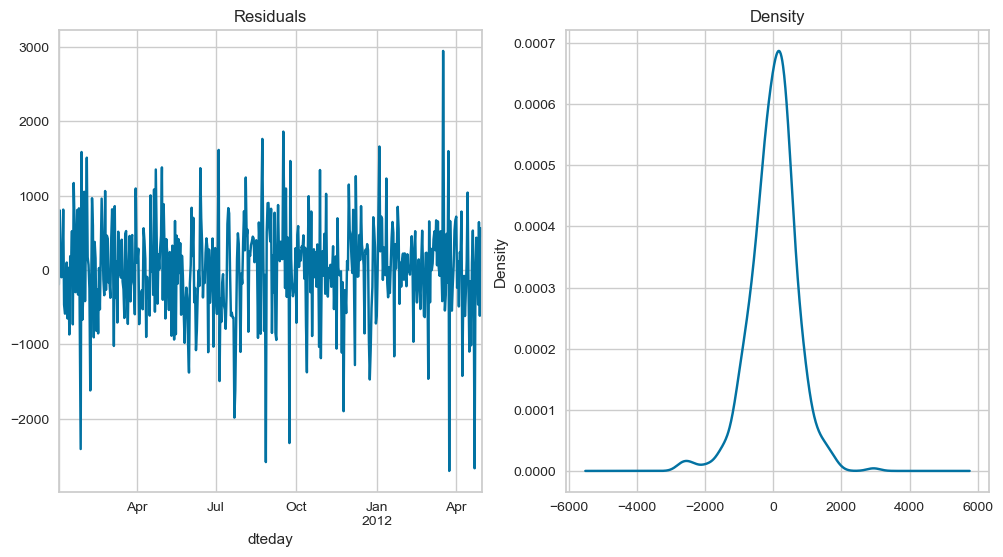

In [47]:
residuals = model_fit.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
residuals.plot(title='Residuals')
plt.subplot2grid((1,2),(0,1))

residuals.plot(title='Density', kind='kde')
plt.show()

Plot prediction + observation

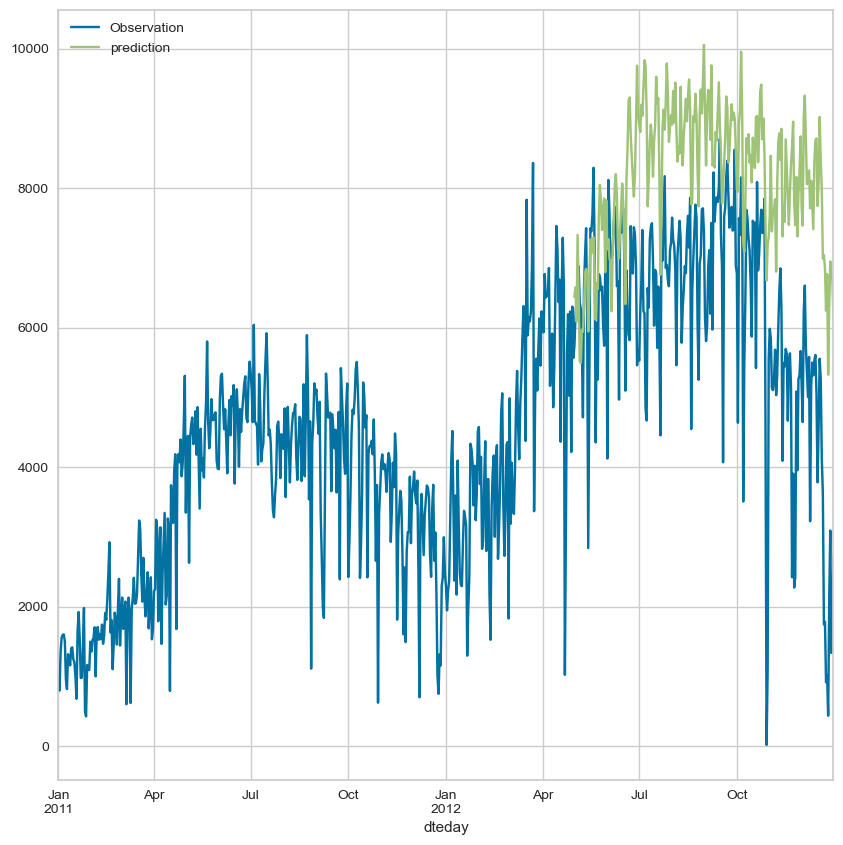

In [48]:
forecast_test = model_fit.forecast(len(x_test),exog=y_test)
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])

zoom in of the prediction from above figure

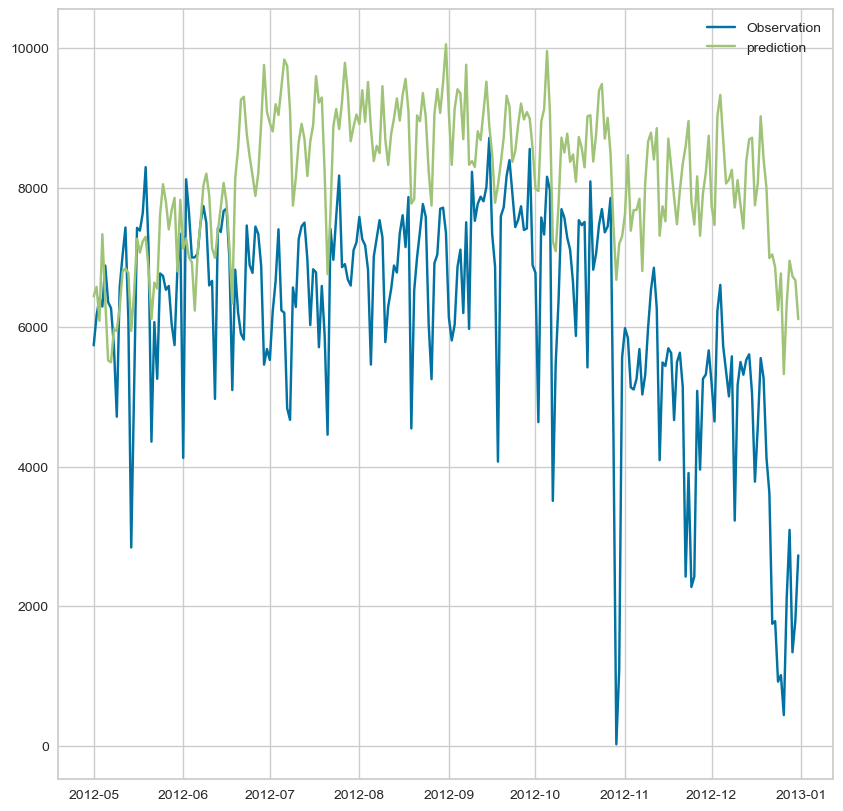

In [49]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

In [50]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  2065.816208833161
Rsquare is:  -1.321877562709863


In [13]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
test.drop(['workingday','mnth','holiday','workingday','atemp','registered','hum','weekday','yr'],axis=1, inplace=True)
train.drop(['workingday','mnth','holiday','workingday','atemp','registered','hum','weekday','yr'], axis=1, inplace=True)

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_5675/2255561322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['workingday','mnth','holiday','workingday','atemp','registered','hum','weekday','yr'],axis=1, inplace=True)
/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_5675/2255561322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['workingday','mnth','holiday','workingday','atemp','registered','hum','weekday','yr'], axis=1, inplace=True)


Change the pdq to see any improvement

In [14]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt'], axis=1)
           

model = SARIMAX(x_train_total,order=(4,1,0),exog=y_train_total,
                                            seasonal_order=(4,1,0,7),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
model_fit=model.fit(disp=False)
model_fit.summary()
print(model_fit.summary())

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  486
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 7)   Log Likelihood               -3559.142
Date:                           Tue, 07 Feb 2023   AIC                           7144.285
Time:                                   05:41:10   BIC                           7197.589
Sample:                               01-01-2011   HQIC                          7165.302
                                    - 04-30-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season       317.4444    137.218      2.313      0.021      48.502     586.387
weathersit  -738.4595     54.540    -13.540

Re-run model with smaller ar

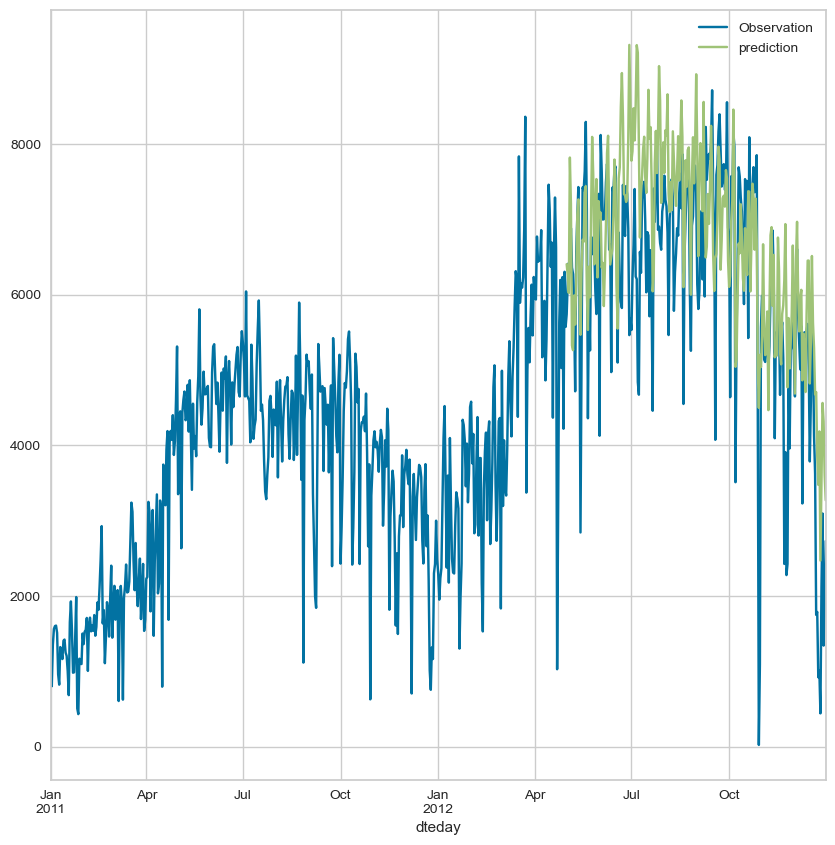

In [15]:
forecast_test = model_fit.forecast(len(x_test),exog=y_test)
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])

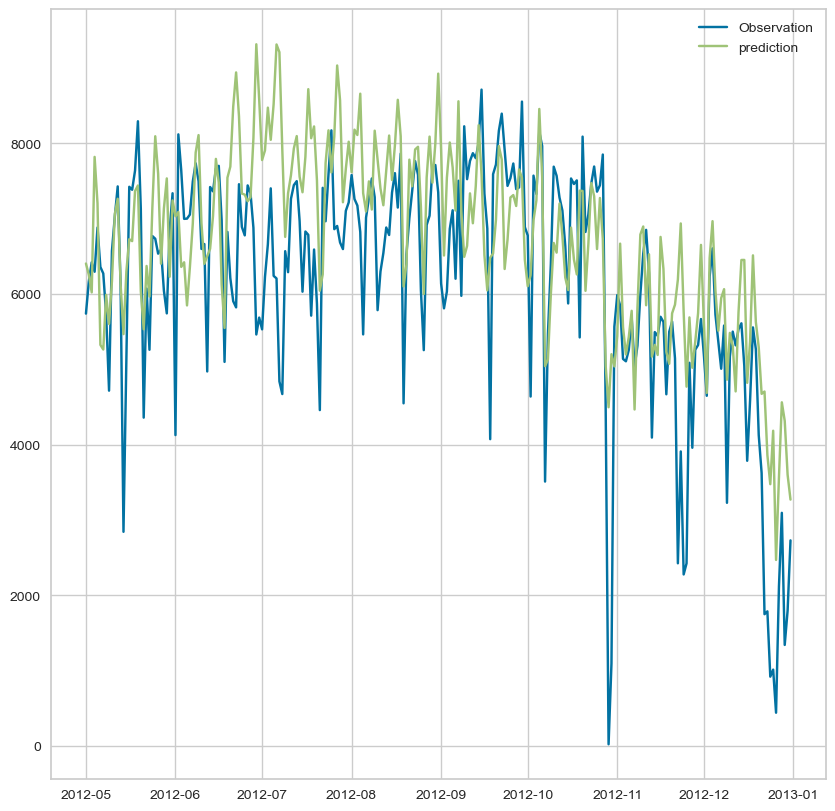

In [16]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

In [17]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  971.6814395846138
Rsquare is:  0.3483324356702143


Let's use Fourier series to include yearly seasonality

In [10]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
test.drop(['workingday','mnth','atemp','registered','hum'],axis=1, inplace=True)
train.drop(['workingday','mnth','atemp','registered','hum'], axis=1, inplace=True)

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_5726/2696766241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['workingday','mnth','atemp','registered','hum'],axis=1, inplace=True)
/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_5726/2696766241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['workingday','mnth','atemp','registered','hum'], axis=1, inplace=True)


cross validation + grid search

In [27]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

warnings.filterwarnings("ignore") # specify to ignore warning messages

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt'], axis=1)
    x_val=validation['cnt']
    exog = pd.DataFrame({'date': y_train.index})
    exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
    exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
    exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
    exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
    exog = exog.drop(columns=['date'])
    y_train = y_train.set_index(pd.PeriodIndex(y_train.index, freq='D'))

    exog=pd.concat([exog,y_train], axis=1)

    AIC=[]
    SARIMAX_model=[]
    q=range(0,3)
    d=range(0,2)
    p=range(0,5)
    pdq=list(itertools.product(p, d, q))
    seas=[(a[0],a[1],a[2], 7)  for a in pdq]
    for param in pdq:
        for param_seasonal in seas:
            try:

                mod = SARIMAX(x_train.values.reshape(-1,1),order=param,exog=exog,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit(disp=False)


                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')

                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue

In [28]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 5990.06542256195 for model SARIMAX(4, 0, 0)x(4, 1, 1, 7)


fiit the model to the whole train dataset

In [33]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt'], axis=1)
exog = pd.DataFrame({'date': y_train_total.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog = exog.drop(columns=['date'])
y_train_total = y_train_total.set_index(pd.PeriodIndex(y_train_total.index, freq='D'))

exog=pd.concat([exog,y_train_total], axis=1)

model=SARIMAX(x_train_total.values.reshape(-1,1), order=SARIMAX_model[AIC.index(min(AIC))][0], seasonal_order= SARIMAX_model[AIC.index(min(AIC))][1],exog=exog,enforce_stationarity=False,
                                            enforce_invertibility=False)

model_fit=model.fit(disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  486
Model:             SARIMAX(4, 0, 0)x(4, 1, [1], 7)   Log Likelihood               -3523.850
Date:                             Tue, 07 Feb 2023   AIC                           7089.699
Time:                                     10:11:47   BIC                           7175.853
Sample:                                 01-01-2011   HQIC                          7123.665
                                      - 04-30-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365       353.2741    172.236      2.051      0.040      15.697     690.851
cos365      -237.2203    167.484     -1.416      0.157    -565.483      91.042
sin365_2    -236.0685    121.180     -1.948      0.051    -473.577       1.440
cos365_2    -244.5173    103.035     -2.373      0.018    -446.462     -42.572
season       375.5853     99.305      3.782      0.000     180.952     570.219
yr          1291.8405    255.326      5.060      0.000     791.411    1792.270
holiday     -307.7664    172.434     -1.785      0.074    -645.731      30.198
weekday       -0.0494    3.2e+04  -1.54e-06      1.000   -6.27e+04    6.27e+04
weathersit  -767.1350     54.172    -14.161      0.000    -873.310    -660.960
temp        4206.3678    476.894      8.820      0.000    3271.672    5141.063
windspeed  -1976.4689    410.984     -4.809      0.000   -2781.984   -1170.954
ar.L1          0.2982      0.043      6.998      0.000       0.215       0.382
ar.L2          0.1433      0.056      2.577      0.010       0.034       0.252
ar.L3         -0.0049      0.060     -0.082      0.935      -0.123       0.113
ar.L4          0.0892      0.054      1.663      0.096      -0.016       0.194
ar.S.L7       -0.0870      0.058     -1.509      0.131      -0.200       0.026
ar.S.L14       0.0446      0.060      0.745      0.456      -0.073       0.162
ar.S.L21      -0.0278      0.058     -0.478      0.633      -0.142       0.086
ar.S.L28       0.0190      0.053      0.361      0.718      -0.084       0.122
ma.S.L7       -1.0983      0.059    -18.494      0.000      -1.215      -0.982
sigma2      3.366e+05   3.62e+04      9.289      0.000    2.66e+05    4.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               144.17
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I remove weekday

In [34]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','weekday'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','weekday'], axis=1)
exog = pd.DataFrame({'date': y_train_total.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog = exog.drop(columns=['date'])
y_train_total = y_train_total.set_index(pd.PeriodIndex(y_train_total.index, freq='D'))

exog=pd.concat([exog,y_train_total], axis=1)

model=SARIMAX(x_train_total.values.reshape(-1,1), order=SARIMAX_model[AIC.index(min(AIC))][0], seasonal_order= SARIMAX_model[AIC.index(min(AIC))][1],exog=exog,enforce_stationarity=False,
                                            enforce_invertibility=False)

model_fit=model.fit(disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  486
Model:             SARIMAX(4, 0, 0)x(4, 1, [1], 7)   Log Likelihood               -3523.850
Date:                             Tue, 07 Feb 2023   AIC                           7087.699
Time:                                     10:12:59   BIC                           7169.750
Sample:                                 01-01-2011   HQIC                          7120.048
                                      - 04-30-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365       353.2741    172.209      2.051      0.040      15.751     690.797
cos365      -237.2204    166.810     -1.422      0.155    -564.163      89.722
sin365_2    -236.0685    121.114     -1.949      0.051    -473.448       1.311
cos365_2    -244.5172    102.648     -2.382      0.017    -445.704     -43.330
season       375.5853     99.287      3.783      0.000     180.987     570.184
yr          1291.8405    254.919      5.068      0.000     792.208    1791.473
holiday     -307.7665    172.367     -1.786      0.074    -645.599      30.066
weathersit  -767.1351     54.167    -14.162      0.000    -873.300    -660.970
temp        4206.3678    476.550      8.827      0.000    3272.347    5140.388
windspeed  -1976.4689    410.301     -4.817      0.000   -2780.644   -1172.293
ar.L1          0.2982      0.043      7.003      0.000       0.215       0.382
ar.L2          0.1433      0.055      2.592      0.010       0.035       0.252
ar.L3         -0.0049      0.060     -0.082      0.935      -0.123       0.113
ar.L4          0.0892      0.054      1.663      0.096      -0.016       0.194
ar.S.L7       -0.0870      0.058     -1.510      0.131      -0.200       0.026
ar.S.L14       0.0446      0.060      0.745      0.456      -0.073       0.162
ar.S.L21      -0.0278      0.058     -0.478      0.633      -0.142       0.086
ar.S.L28       0.0190      0.053      0.361      0.718      -0.084       0.122
ma.S.L7       -1.0983      0.059    -18.515      0.000      -1.215      -0.982
sigma2      3.366e+05   3.62e+04      9.295      0.000    2.66e+05    4.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               144.17
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot residuals

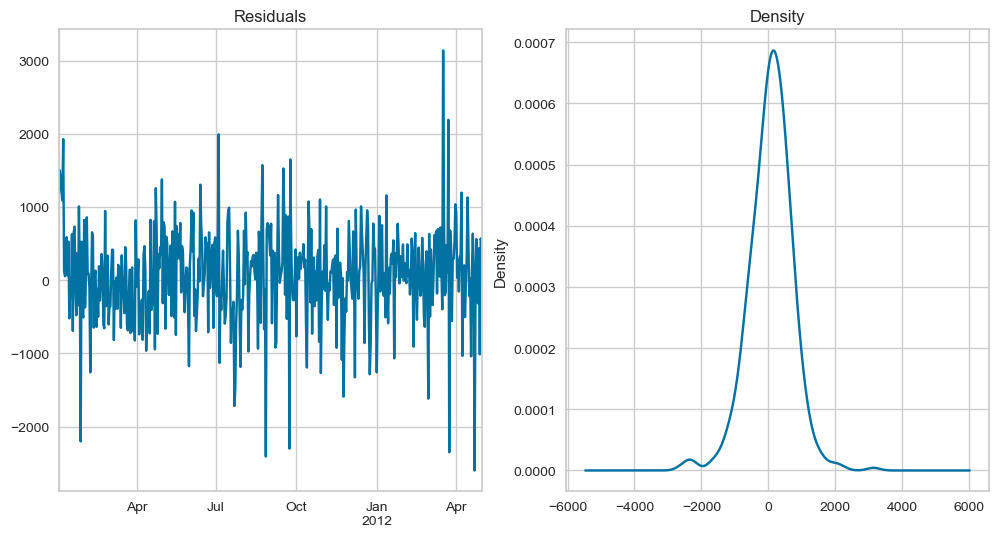

In [35]:
residuals = model_fit.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
residuals.plot(title='Residuals')
plt.subplot2grid((1,2),(0,1))

residuals.plot(title='Density', kind='kde')
plt.show()

Plot prediction + observation

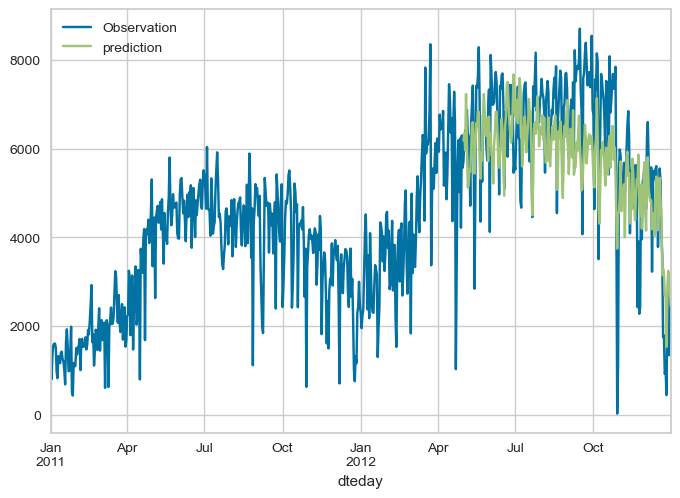

In [43]:
exog = pd.DataFrame({'date': y_test.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog = exog.drop(columns=['date'])
y_test = y_test.set_index(pd.PeriodIndex(y_test.index, freq='D'))

exog=pd.concat([exog,y_test], axis=1)
forecast_test = model_fit.forecast(len(x_test),exog=exog)
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])

oom in of above figure

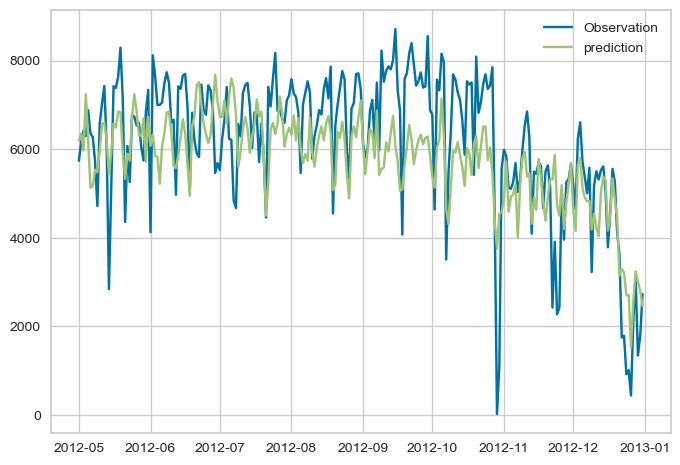

In [44]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

MAE and R square

In [45]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  952.5027494503996
Rsquare is:  0.4752650610037684


I change the pdq a little 

In [47]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','weekday'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','weekday'], axis=1)
exog = pd.DataFrame({'date': y_train_total.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog = exog.drop(columns=['date'])
y_train_total = y_train_total.set_index(pd.PeriodIndex(y_train_total.index, freq='D'))

exog=pd.concat([exog,y_train_total], axis=1)

model=SARIMAX(x_train_total.values.reshape(-1,1), order=(4, 0, 0), seasonal_order= (4, 0, 0, 7),exog=exog,enforce_stationarity=False,
                                            enforce_invertibility=False)

model_fit=model.fit(disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  486
Model:             SARIMAX(4, 0, 0)x(4, 0, 0, 7)   Log Likelihood               -3579.144
Date:                           Tue, 07 Feb 2023   AIC                           7196.289
Time:                                   10:24:02   BIC                           7274.533
Sample:                               01-01-2011   HQIC                          7227.116
                                    - 04-30-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365       554.1793    155.877      3.555      0.000     248.666     859.693
cos365       297.8676    149.824      1.988      0.047       4.217     591.518
sin365_2    -221.7097    126.547     -1.752      0.080    -469.737      26.318
cos365_2    -194.4793    110.556     -1.759      0.079    -411.165      22.206
season       548.8744     84.199      6.519      0.000     383.846     713.902
yr          1956.3579    182.317     10.731      0.000    1599.023    2313.693
holiday     -426.4579    168.289     -2.534      0.011    -756.298     -96.618
weathersit  -638.6198     51.534    -12.392      0.000    -739.625    -537.614
temp        6450.1452    389.586     16.556      0.000    5686.570    7213.721
windspeed  -1768.5407    395.994     -4.466      0.000   -2544.675    -992.406
ar.L1          0.3333      0.042      7.853      0.000       0.250       0.416
ar.L2          0.0995      0.057      1.753      0.080      -0.012       0.211
ar.L3         -0.0340      0.067     -0.505      0.613      -0.166       0.098
ar.L4          0.0756      0.056      1.357      0.175      -0.034       0.185
ar.S.L7       -0.0142      0.042     -0.338      0.735      -0.097       0.068
ar.S.L14       0.0910      0.046      1.999      0.046       0.002       0.180
ar.S.L21       0.0543      0.049      1.110      0.267      -0.042       0.150
ar.S.L28       0.0586      0.050      1.175      0.240      -0.039       0.156
sigma2      4.167e+05   2.22e+04     18.750      0.000    3.73e+05     4.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               185.47
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot observation + prediction

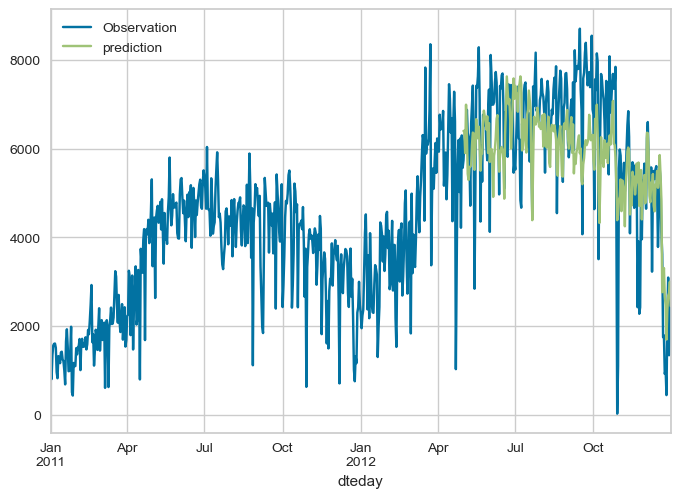

In [48]:
exog = pd.DataFrame({'date': y_test.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog = exog.drop(columns=['date'])
y_test = y_test.set_index(pd.PeriodIndex(y_test.index, freq='D'))

exog=pd.concat([exog,y_test], axis=1)
forecast_test = model_fit.forecast(len(x_test),exog=exog)
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])

zoom in of the above figure

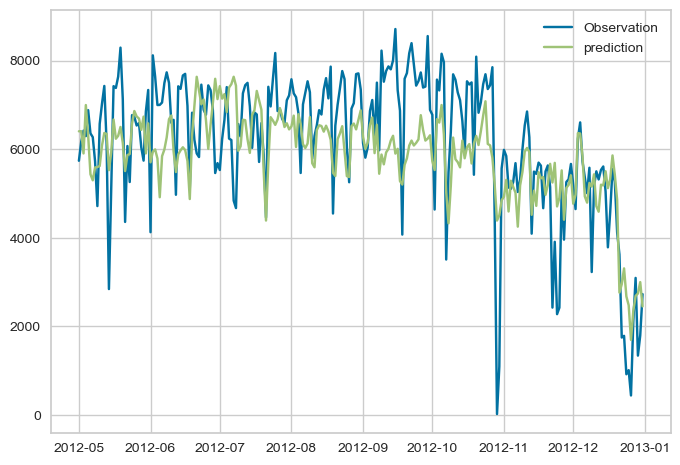

In [49]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

MAE and R square

In [50]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  951.5376870725352
Rsquare is:  0.4632964502926292


In [18]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
test.drop(['workingday','mnth','atemp','registered','hum'],axis=1, inplace=True)
train.drop(['workingday','mnth','atemp','registered','hum'], axis=1, inplace=True)

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_7861/2696766241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['workingday','mnth','atemp','registered','hum'],axis=1, inplace=True)
/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_7861/2696766241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['workingday','mnth','atemp','registered','hum'], axis=1, inplace=True)


I test the model with seasonality of 8 days

In [78]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','weekday'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','weekday'], axis=1)
exog = pd.DataFrame({'date': y_train_total.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.0)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.0)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.0)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.0)
exog = exog.drop(columns=['date'])
y_train_total = y_train_total.set_index(pd.PeriodIndex(y_train_total.index, freq='D'))

exog=pd.concat([exog,y_train_total], axis=1)

model=SARIMAX(x_train_total.values.reshape(-1,1), order=(4, 0, 0), seasonal_order= (4, 0, 0, 8),exog=exog,enforce_stationarity=False,
                                            enforce_invertibility=False)

model_fit=model.fit(disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  486
Model:             SARIMAX(4, 0, 0)x(4, 0, 0, 8)   Log Likelihood               -3546.518
Date:                           Tue, 07 Feb 2023   AIC                           7131.036
Time:                                   17:02:51   BIC                           7209.112
Sample:                               01-01-2011   HQIC                          7161.809
                                    - 04-30-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365       548.5051    137.657      3.985      0.000     278.702     818.308
cos365       269.7610    125.997      2.141      0.032      22.811     516.711
sin365_2    -238.4438    111.062     -2.147      0.032    -456.122     -20.766
cos365_2    -223.8216     94.588     -2.366      0.018    -409.211     -38.432
season       611.7857     86.008      7.113      0.000     443.213     780.358
yr          1963.1947    165.881     11.835      0.000    1638.073    2288.316
holiday     -414.1043    158.407     -2.614      0.009    -724.576    -103.633
weathersit  -701.6176     52.163    -13.450      0.000    -803.856    -599.379
temp        6458.4080    390.320     16.546      0.000    5693.395    7223.421
windspeed  -1767.1389    373.481     -4.732      0.000   -2499.148   -1035.130
ar.L1          0.3508      0.046      7.703      0.000       0.262       0.440
ar.L2          0.0623      0.059      1.047      0.295      -0.054       0.179
ar.L3         -0.0358      0.070     -0.511      0.609      -0.173       0.101
ar.L4          0.0590      0.058      1.021      0.307      -0.054       0.172
ar.S.L8        0.0941      0.052      1.797      0.072      -0.009       0.197
ar.S.L16      -0.0238      0.058     -0.413      0.679      -0.137       0.089
ar.S.L24       0.0373      0.051      0.735      0.462      -0.062       0.137
ar.S.L32      -0.0642      0.054     -1.196      0.232      -0.169       0.041
sigma2      4.107e+05   2.08e+04     19.777      0.000     3.7e+05    4.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               205.38
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.56
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot prediction + observation

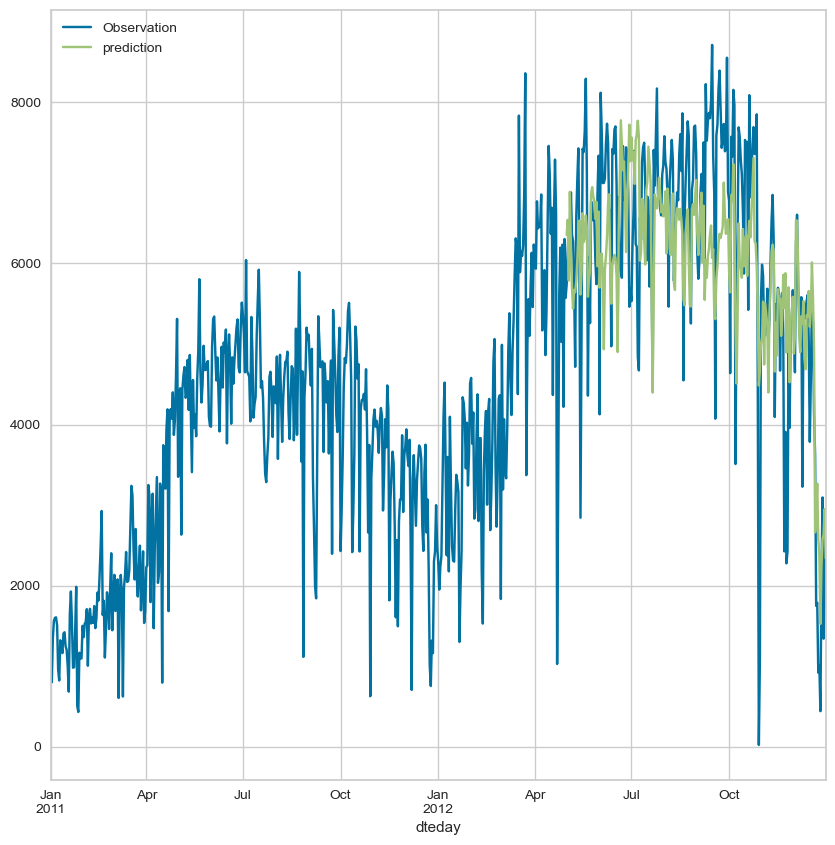

In [79]:
exog = pd.DataFrame({'date': y_test.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.0)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.0)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.0)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.0)
exog = exog.drop(columns=['date'])
y_test = y_test.set_index(pd.PeriodIndex(y_test.index, freq='D'))

exog=pd.concat([exog,y_test], axis=1)
forecast_test = model_fit.forecast(len(x_test),exog=exog)
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])

Zoom in of the above figure

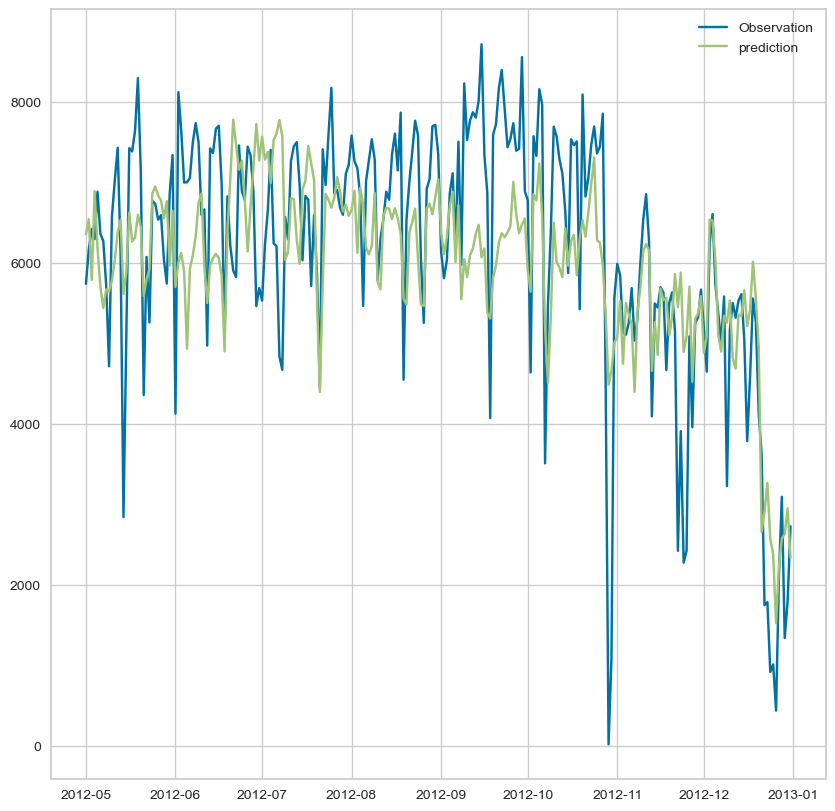

In [80]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

MAE and R square

In [81]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  897.6562887151186
Rsquare is:  0.4998499507401343
